In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from model.resnet import ResNet18
from model.resnext import CifarResNeXt
from model.wrn import WideResNet
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim
from torchsummary import summary
from tqdm import tqdm

#### Loading student and teacher models

In [2]:
resnet18 = ResNet18() # student model
resnext = CifarResNeXt(cardinality=8, depth=29, num_classes=10)

wrn = WideResNet(depth=28, num_classes=10, widen_factor=10, dropRate=0.3)

resnet18.load_state_dict(torch.load('./experiments/resnet18_distill/wrn_teacher/best.pth.tar', map_location='cpu')['state_dict'])


state_dict = torch.load('./experiments/base_wrn/best.pth.tar', map_location='cpu')['state_dict']
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
wrn.load_state_dict(new_state_dict)


state_dict = torch.load('./experiments/base_resnext29/best.pth.tar', map_location='cpu')['state_dict']
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
resnext.load_state_dict(new_state_dict)

/Users/aayush/Code_Shits/knowledge-distillation-pytorch/model/resnext.py:82: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.classifier.weight)
/Users/aayush/Code_Shits/knowledge-distillation-pytorch/model/resnext.py:87: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.state_dict()[key], mode='fan_out')


<All keys matched successfully>

In [3]:
train_transformer = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
        ])

trainset = torchvision.datasets.CIFAR10(root='./data-cifar10', train=True, download=True, transform=train_transformer)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


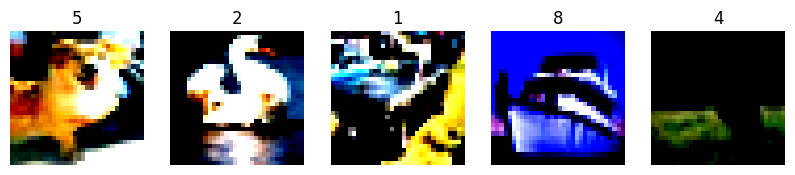

In [4]:
sample_train_batch, smaple_labels_batch = next(iter(trainloader))
fig, ax = plt.subplots(1, 5, figsize=(10, 10))
for i in range(5):
    ax[i].imshow(sample_train_batch[i].numpy().transpose(1, 2, 0))
    ax[i].set_title(smaple_labels_batch[i].item())
    ax[i].axis('off')

In [5]:
# for name, param in wrn.named_parameters():
#     print(name, param.shape)

# import torchvision.models as models
# model = models.resnet50(pretrained=True)
# # print(model.layer4)

# for name, param in model.named_parameters():
#     print(name, param.shape)

#### Registering the forward hooks

In [6]:
# register forward hook before the average pooling layer
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# adding forward hook to the penultimate relu layer to the student and teacher model
resnet18.layer4[1].shortcut.register_forward_hook(get_activation('shortcut'))
wrn.relu.register_forward_hook(get_activation('relu'))

#### Utility functions

In [7]:
# these are the weights we will use for class activation mapping
def get_fc_params(model, name):
    fc_params = torch.tensor([])
    for n, param in model.named_parameters():
        if n == name:
            fc_params = param
            # print(n, param.shape)
    return fc_params

In [8]:
def get_weighted_CAM(forward_hooked_model, input, weights, student = True, rescale=True):
    if student:
        key = 'shortcut'
        layer_size = 512
        resize_val = 4
    else:
        key = 'relu'
        layer_size = 640
        resize_val = 8
    predictions = forward_hooked_model(input) # torch.unsqueeze(train_batch[index], 0)
    # print(activation.keys())
    activation[key] = activation[key][0]
    activation[key] = activation[key].permute(1, 2, 0)
    activation[key] = activation[key].reshape(-1, layer_size)

    activation_map = torch.matmul(activation[key], weights)
    activation_map = activation_map.reshape(resize_val, resize_val)
    
    if rescale:
        activation_map = activation_map - torch.min(activation_map)
        activation_map = activation_map / (torch.max(activation_map) - torch.min(activation_map))
        # activation_map = activation_map * 255

    return activation_map, predictions

#### Teacher model

In [9]:
fc_params_teacher = get_fc_params(wrn, 'fc.weight')

In [10]:
train_iter = iter(trainloader)
_batch = next(train_iter)
current_input_batch = _batch[0]
current_label_batch = _batch[1]
print(current_input_batch.shape, current_label_batch.shape)

train_transformer_2 = transforms.Compose([
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

complexity_values_teacher = []
drop_values_teacher = []
ssim_score_teacher = []
adcc_score_teacher = []

for i in tqdm(range(current_input_batch.shape[0])):
    activation_map, predictions = get_weighted_CAM(wrn, torch.unsqueeze(current_input_batch[i], 0), fc_params_teacher[current_label_batch[i]], student=False)
    activation_map = activation_map.detach().numpy() # CAMc(x)

    complexity_values_teacher.append(np.linalg.norm(activation_map, ord=1))

    activation_map = cv2.resize(activation_map, (32, 32)) # 32 x 32

    original_image = current_input_batch[i].numpy()
    original_image = original_image - np.min(original_image)
    original_image = original_image / np.max(original_image)
    original_image = original_image * 255
    original_image = original_image.astype(np.uint8)

    occluded_image = original_image * np.stack((activation_map, activation_map, activation_map)) # 3 X 32 x 32
    occluded_image -= np.min(occluded_image)
    occluded_image /= np.max(occluded_image)
    occluded_image = occluded_image.astype(float) # 3 x 32 x 32

    occluded_image = torch.tensor(occluded_image).float()
    occluded_image = train_transformer_2(occluded_image)
    
    occluded_activations, occluded_predictions = get_weighted_CAM(wrn, torch.unsqueeze(occluded_image, 0), fc_params_teacher[current_label_batch[i]], student=False)
    occluded_activations = occluded_activations.detach().numpy()
    occluded_activations = cv2.resize(occluded_activations, (32, 32)) # 32 x 32
    # occluded_predictions = wrn(torch.unsqueeze(occluded_image, 0))

    prediction_label_from_original_image = torch.argmax(predictions, dim=1).item()
    prediction_label_from_occluded_image = torch.argmax(occluded_predictions, dim=1).item()

    prob_pred_from_original_image = torch.max(predictions, dim=1).values.item()
    prob_pred_from_occluded_image = torch.max(occluded_predictions, dim=1).values.item()
    fraction_drop = (prob_pred_from_original_image - prob_pred_from_occluded_image) / prob_pred_from_original_image

    drop_values_teacher.append(max(0, fraction_drop))
    ssim_score_teacher.append(ssim(activation_map, occluded_activations, data_range=occluded_activations.max() - occluded_activations.min()))

    adcc_score = 3 / (1/ssim_score_teacher[-1] + 1/(1 - complexity_values_teacher[-1]) + 1/(1 - drop_values_teacher[-1]))
    adcc_score_teacher.append(adcc_score)

torch.Size([100, 3, 32, 32]) torch.Size([100])


100%|██████████| 100/100 [00:07<00:00, 13.14it/s]


In [11]:
print("For teacher model, Mean complexity values: ", np.mean(complexity_values_teacher))
print("For teacher model, Mean drop values: ", np.mean(drop_values_teacher))
print("For teacher model, Mean SSIM values: ", np.mean(ssim_score_teacher))
print("For teacher model, Mean Final ADCC values: ", np.mean(adcc_score_teacher))

For teacher model, Mean complexity values:  5.637239
For teacher model, Mean drop values:  0.15608044925344056
For teacher model, Mean SSIM values:  0.5753391287291664
For teacher model, Mean Final ADCC values:  1.062856963828532


#### Student Model

In [12]:
fc_params_student = get_fc_params(resnet18, 'linear.weight')

In [13]:
complexity_values_student = []
drop_values_student = []
ssim_score_students = []
adcc_score_student = []

for i in tqdm(range(current_input_batch.shape[0])):
    activation_map, predictions = get_weighted_CAM(resnet18, torch.unsqueeze(current_input_batch[i], 0), fc_params_student[current_label_batch[i]], student=True)
    activation_map = activation_map.detach().numpy() # CAMc(x)

    complexity_values_student.append(np.linalg.norm(activation_map, ord=1))

    activation_map = cv2.resize(activation_map, (32, 32)) # 32 x 32

    original_image = current_input_batch[i].numpy()
    original_image = original_image - np.min(original_image)
    original_image = original_image / np.max(original_image)
    original_image = original_image * 255
    original_image = original_image.astype(np.uint8)

    occluded_image = original_image * np.stack((activation_map, activation_map, activation_map)) # 3 X 32 x 32
    occluded_image -= np.min(occluded_image)
    occluded_image /= np.max(occluded_image)
    occluded_image = occluded_image.astype(float) # 3 x 32 x 32

    occluded_image = torch.tensor(occluded_image).float()
    occluded_image = train_transformer_2(occluded_image)

    occluded_activations, occluded_predictions = get_weighted_CAM(resnet18, torch.unsqueeze(occluded_image, 0), fc_params_student[current_label_batch[i]], student=True)
    occluded_activations = occluded_activations.detach().numpy()
    occluded_activations = cv2.resize(occluded_activations, (32, 32)) # 32 x 32
    # occluded_predictions = resnet18(torch.unsqueeze(occluded_image, 0))

    prediction_label_from_original_image = torch.argmax(predictions, dim=1).item()
    prediction_label_from_occluded_image = torch.argmax(occluded_predictions, dim=1).item()

    prob_pred_from_original_image = torch.max(predictions, dim=1).values.item()
    prob_pred_from_occluded_image = torch.max(occluded_predictions, dim=1).values.item()
    fraction_drop = (prob_pred_from_original_image - prob_pred_from_occluded_image) / prob_pred_from_original_image

    drop_values_student.append(max(0, fraction_drop))
    ssim_score_students.append(ssim(activation_map, occluded_activations, data_range=occluded_activations.max() - occluded_activations.min()))

    adcc_score = 3 / (1/ssim_score_students[-1] + 1/(1 - complexity_values_student[-1]) + 1/(1 - drop_values_student[-1]))
    adcc_score_student.append(adcc_score)

100%|██████████| 100/100 [00:02<00:00, 47.09it/s]


In [14]:
print("For student model, Mean complexity values: ", np.mean(complexity_values_student))
print("For student model, Mean drop values: ", np.mean(drop_values_student))
print("For student model, Mean SSIM values: ", np.mean(ssim_score_students))
print("For student model, Mean Final ADCC values: ", np.mean(adcc_score_student))

For student model, Mean complexity values:  2.8030732
For student model, Mean drop values:  0.12172973096851333
For student model, Mean SSIM values:  0.6607957362347788
For student model, Mean Final ADCC values:  1.3869346751191705


#### Visualising

In [15]:
print(smaple_labels_batch)

tensor([5, 2, 1, 8, 4, 6, 2, 5, 8, 6, 3, 7, 1, 3, 0, 0, 3, 1, 5, 1, 5, 9, 8, 4,
        2, 9, 9, 7, 4, 8, 0, 5, 8, 2, 4, 6, 5, 8, 1, 2, 6, 3, 6, 9, 0, 8, 2, 9,
        8, 4, 1, 2, 0, 5, 6, 8, 6, 5, 0, 9, 0, 6, 5, 2, 3, 9, 5, 1, 3, 8, 2, 1,
        4, 5, 4, 9, 7, 5, 3, 2, 8, 1, 8, 8, 4, 1, 5, 8, 5, 2, 4, 5, 8, 1, 1, 7,
        4, 6, 6, 4])


torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])


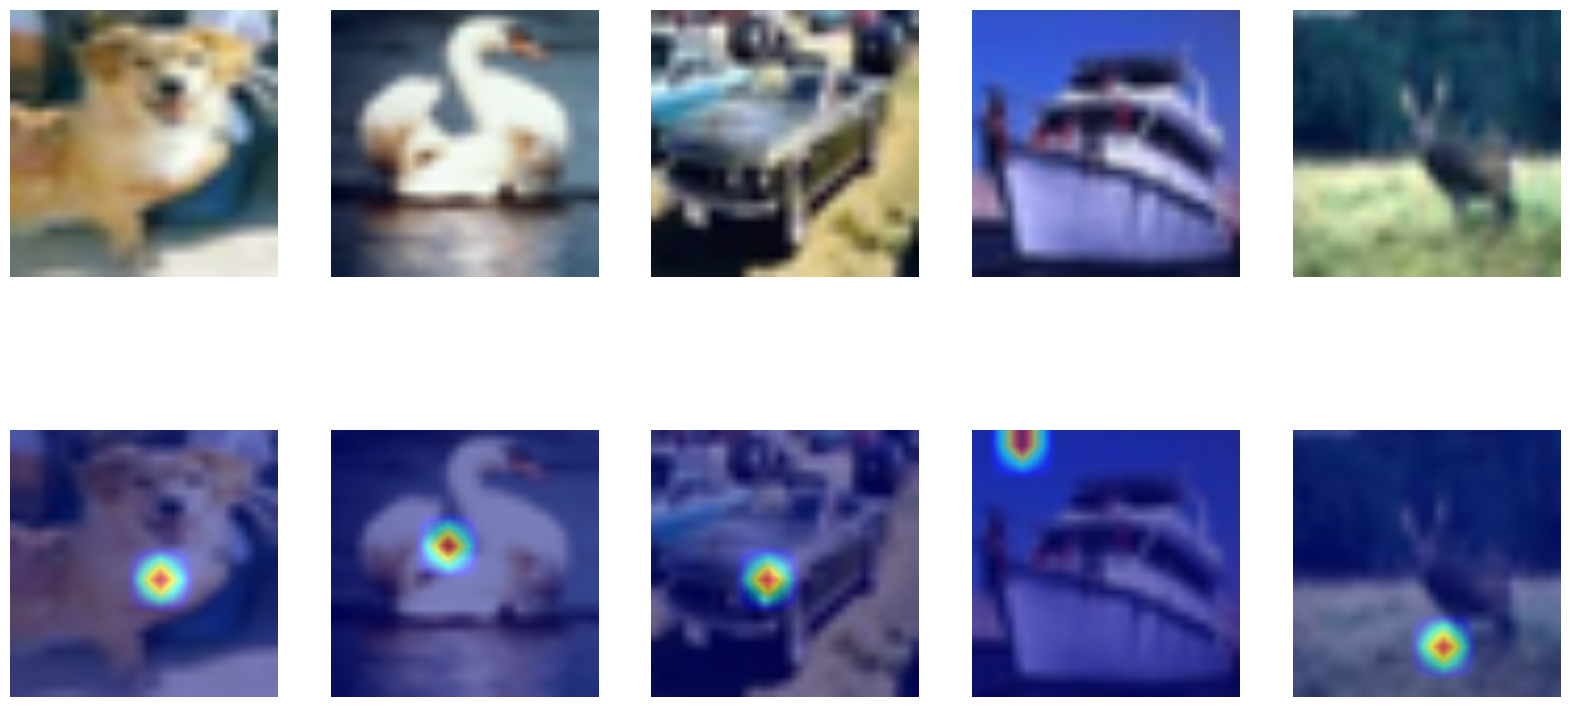

In [16]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
fc_params_teacher = get_fc_params(wrn, 'fc.weight')

for i in range(5):
    activation = {}
    activation_map, _ = get_weighted_CAM(wrn, torch.unsqueeze(sample_train_batch[i], 0), fc_params_teacher[smaple_labels_batch[i]], student=False)
    print(activation_map.shape)
    activation_map = activation_map.detach().numpy().astype(np.uint8)
    activation_map *= 255
    
    activation_map = cv2.resize(activation_map, (224, 224))
    activation_map = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)
    activation_map = cv2.cvtColor(activation_map, cv2.COLOR_BGR2RGB)
    
    original_image = sample_train_batch[i].numpy().transpose(1, 2, 0)
    original_image = original_image - np.min(original_image)
    original_image = original_image / np.max(original_image)
    original_image = original_image * 255
    original_image = original_image.astype(np.uint8)
    original_image = cv2.resize(original_image, (224, 224))

    activation_map = cv2.addWeighted(original_image, 0.5, activation_map, 0.5, 0)

    axes[0][i].imshow(original_image)
    axes[0][i].axis('off')
    axes[1][i].imshow(activation_map)
    axes[1][i].axis('off')

In [17]:
# fig, axes = plt.subplots(2, 5, figsize=(20, 10))

# for i in range(5):  
#     activation_map, _ = get_weighted_CAM(resnet18, torch.unsqueeze(sample_train_batch[i], 0), fc_params_student[smaple_labels_batch[i]], student=True)

#     activation_map = activation_map.detach().numpy().astype(np.uint8)

#     activation_map = cv2.resize(activation_map, (224, 224)) # 224 x 224
#     activation_map = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)
#     activation_map = cv2.cvtColor(activation_map, cv2.COLOR_BGR2RGB)
#     original_image = sample_train_batch[i].numpy().transpose(1, 2, 0)
#     original_image = original_image - np.min(original_image)
#     original_image = original_image / np.max(original_image)
#     original_image = original_image * 255
#     original_image = original_image.astype(np.uint8)

#     original_image = cv2.resize(original_image, (224, 224))

#     activation_map = cv2.addWeighted(original_image, 0.5, activation_map, 0.5, 0)

#     axes[0][i].imshow(original_image)
#     axes[0][i].axis('off')
#     axes[1][i].imshow(activation_map)
#     axes[1][i].axis('off')

In [18]:
# fig, axes = plt.subplots(2, 5, figsize=(20, 10))
# activation_maps_teacher = []
# threshold = 0.6
# occluded_images = []

# for i in range(5):
#     activation_map, _ = get_weighted_CAM(wrn, torch.unsqueeze(sample_train_batch[i], 0), fc_params_teacher[smaple_labels_batch[i]], student=False)
#     activation_map = activation_map.detach().numpy().astype(np.uint8)
#     activation_map = cv2.resize(activation_map, (32, 32))

#     original_image = sample_train_batch[i].numpy().transpose(1, 2, 0)
#     original_image = original_image - np.min(original_image)
#     original_image = original_image / np.max(original_image)

#     occluded_image = original_image * np.stack((activation_map, activation_map, activation_map)).transpose(1, 2, 0)

#     original_image = original_image * 255
#     original_image = original_image.astype(np.uint8)

#     # activation_map = np.ones((32, 32))
#     # occluded_image = original_image * np.stack((activation_map, activation_map, activation_map)).transpose(1, 2, 0)
#     occluded_image -= np.min(occluded_image)
#     occluded_image /= np.max(occluded_image)
#     occluded_image *= 255
#     occluded_image = occluded_image.astype(np.uint8)


#     axes[0][i].imshow(original_image)
#     axes[0][i].axis('off')
#     axes[1][i].imshow(occluded_image)
#     axes[1][i].axis('off')

#     occluded_image = occluded_image.astype(float)
#     occluded_image -= np.min(occluded_image)
#     occluded_image /= np.max(occluded_image)
#     occluded_images.append(occluded_image.transpose(2, 0, 1))

# occluded_images = torch.tensor(occluded_images).float()

##### Ignore

In [19]:
# summary(resnet18, (3, 32, 32))
# summary(wrn, (3, 32, 32))
# summary(resnext, (3, 32, 32))

In [20]:
# print(occluded_images.shape, occluded_image.dtype)

# # samp = occluded_images[0]
# # plt.imshow(samp.numpy().transpose(1, 2, 0).astype(np.uint8))

# # print(occluded_images[0].shape)
# # plt.imshow(occluded_images[0].numpy().transpose(1, 2, 0).astype(np.uint8))
# train_transformer_2 = transforms.Compose([
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
# ])
# occluded_images = train_transformer_2(occluded_images)
# # temp = train_transformer_2(occluded_images[0])
# # print(temp.shape)

# wrn.eval()
# true_prediction_probability = wrn(sample_train_batch[:5])
# occluded_prediction_probability = wrn(occluded_images)
# # occluded_prediction_probability = wrn(temp.unsqueeze(0))
# print(torch.argmax(occluded_prediction_probability, dim=1), smaple_labels_batch[:5], torch.argmax(true_prediction_probability, dim=1))